# Data Visualization

## Libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import json

## Constants

In [64]:
PATH = "../../"
IMAGES_PATH = PATH + "Dataset/images/"

csv_file = PATH + "Data/CSVs/dataset_caltech_yolo.csv"

predictions_file = PATH + "new_predictions.json"

In [65]:
species_mapping = {
    0: "bird",
    1: "cow",
    2: "domestic dog",
    3: "egyptian mongoose",
    4: "european badger",
    5: "european rabbit",
    6: "fallow deer",
    7: "genet",
    8: "horse",
    9: "human",
    10: "iberian hare",
    11: "iberian lynx",
    12: "red deer",
    13: "red fox",
    14: "wild boar",

    213: "canidae",
    510: "leporid",
    612: "cervid",

    1000: "animal"
}

inverted_species_mapping = {value: key for key, value in species_mapping.items()}

family_mapping = {
    "bird": "",
    "cow": "",
    "domestic dog": "canidae",
    "egyptian mongoose": "",
    "european badger": "",
    "european rabbit": "leporid",
    "fallow deer": "cervid",
    "genet": "",
    "horse": "",
    "human": "",
    "iberian hare": "leporid",
    "iberian lynx": "",
    "red deer": "cervid",
    "red fox": "canidae",
    "wild boar": "",
}

# Create the inverted dictionary
inverted_family_mapping = {}
for key, value in family_mapping.items():
    if value:
        if value not in inverted_family_mapping:
            inverted_family_mapping[value] = [key]
        else:
            inverted_family_mapping[value].append(key)


species_color_mapping = {
    0: "#FCF7FF", #"bird",
    1: "#FF924C", #"cow",
    2: "#E85155",#"domestic dog", =====================================
    3: "#FFCA3A",#"egyptian mongoose",
    4: "#4267AC",#"european badger",
    5: '#8AC926', #"european rabbit",
    6: '#A64692', #"fallow deer",
    7: "#6A4C93",#"genet",
    8: "#A1E8CC",#"horse",
    9: "#4B4237",#"human",
    10: '#C5CA30', #"iberian hare",
    11: "#41D3BD",#"iberian lynx",
    12: '#E067A7', #"red deer",
    13: "#FF595E",#"red fox",
    14: "#BFD7EA",#"wild boar",

    213: "#C04346", #"canidae",
    510: '#52A675', #"leporid",
    612: '#D43087', #"cervid",

    1000: "#1C0221", #"animal"
}

In [66]:
def get_species_names_from_family_names(family_name):
    return inverted_family_mapping[family_name]

def get_specie_id_from_specie_name(specie_name):
    return inverted_species_mapping[specie_name]

def get_specie_name_from_specie_id(specie_id):
    return species_mapping[specie_id]

def get_family_name_from_specie_id(specie_id): # get_family_name_from_specie_id(12)
    return family_mapping[species_mapping[specie_id]]

def get_family_id_from_specie_id(specie_id): # get_family_name_from_specie_id(12)
    return inverted_species_mapping[family_mapping[species_mapping[specie_id]]]

def get_family_name_from_family_id(family_id):
    return species_mapping[family_id]

In [67]:
# Load the files
df = pd.read_csv(csv_file)

with open(predictions_file, "r") as f:
    predictions_data = json.load(f)

## Functions

In [68]:
# Convert bbox from [x-center, y-center, width, height] to [x1, y1, width, height]
def convert_box(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    width = width * img_width
    height = height * img_height

    return x_min, y_min, width, height

In [69]:
def unique_imagesids_from_predictions(list):
    unique_image_ids = []
    [unique_image_ids.append(prediction["image_id"]) for prediction in predictions_data if prediction["image_id"] not in unique_image_ids]

    return unique_image_ids

In [70]:
def filter_predictions(predictions_data, mode, n = 10, category_id = None, original_category_id = None):
    # Ensure mode is valid
    if mode not in ["best", "worst"]:
        raise ValueError("Invalid mode. Use 'best' or 'worst'.")

    # Sort the predictions_data based on the score
    sorted_predictions = sorted(predictions_data, key=lambda x: x["score"], reverse=(mode == "best"))
    
    unique_sorted_predictions = []
    if category_id is not None:
        [unique_sorted_predictions.append(prediction["image_id"]) for prediction in sorted_predictions if prediction["image_id"] not in unique_sorted_predictions and prediction["category_id"] == category_id]
    elif original_category_id is not None:
        for prediction in sorted_predictions:
            if prediction["image_id"] not in unique_sorted_predictions and "original_category_id" in prediction:
                if prediction["original_category_id"] == original_category_id:
                    unique_sorted_predictions.append(prediction["image_id"])
    else:
        [unique_sorted_predictions.append(prediction["image_id"]) for prediction in sorted_predictions if prediction["image_id"] not in unique_sorted_predictions]

    # Extract the top n image IDs
    top_n_image_ids = unique_sorted_predictions[:n]

    return top_n_image_ids

In [79]:
def plot_n_images_from_imageids_list(image_id_list, n=None):
    if not n: n = len(image_id_list)
    # Iterate through predictions
    for image_id in image_id_list[:n]:  # Change the number of predictions you want to process

        # Find corresponding row in CSV
        csv_row = df[df["path"].str.contains(image_id, regex=False)]

        gt_bboxes = eval(csv_row["bounding_boxes"].values[0])

        filtered_predictions = [prediction for prediction in predictions_data if prediction["image_id"] == image_id]

        # Initialize lists to store the extracted fields
        category_ids = []
        original_category_ids = []
        scores = []
        original_scores = []
        bboxes = []

        # Loop through filtered predictions to extract fields
        for prediction in filtered_predictions:
            category_id = prediction["category_id"]
            original_category_id = ""
            original_score = ""
            color = species_color_mapping[category_id]
            if "original_category_id" in prediction:
                original_category_id = prediction["original_category_id"]
                original_score = prediction["original_score"]
                color = species_color_mapping[category_id]

            score = prediction["score"]
            bbox = prediction["bbox"]

            category_ids.append(category_id)
            scores.append(score)
            bboxes.append(bbox)

            original_category_ids.append(original_category_id)
            original_scores.append(original_score)

        if not csv_row.empty:
            image_path = IMAGES_PATH + csv_row["path"].values[0]

            # Load image
            img = Image.open(image_path)
            img_width, img_height = img.size

            fig, ax = plt.subplots()
            ax.imshow(img)

            # Ground Truth boxes
            for bbox in gt_bboxes:

                category_id = bbox[0]
                category_name = species_mapping.get(category_id, "Unknown")

                bbox = convert_box(bbox[1:], img_width, img_height)

                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), 
                    bbox[2], 
                    bbox[3], 
                    linewidth=5, 
                    edgecolor='g',
                    alpha=0.5, 
                    label=f"GT: {category_name}",
                    facecolor='none')
                
                ax.add_patch(rect)

                # Show class on plot
                plt.text(
                    bbox[0], #+ bbox[2] - 100,#-220, 
                    bbox[1]-130,#+bbox[3]+100,
                    f"{category_name}",
                    color="k",
                    backgroundcolor="g",
                    fontsize=7,
                    alpha=0.8,
                )

            # Predicted boxes
            for idx, bbox in enumerate(bboxes):

                category_id = category_ids[idx]
                original_category_id = original_category_ids[idx]
                original_score = original_scores[idx]
                original_category_name = species_mapping.get(original_category_id, "Unknown")
                category_name = species_mapping.get(category_id, "Unknown")
                score = scores[idx]

                if original_category_id != "":
                    label = f"{category_name}, {score:.2f} ({original_category_name}, {original_score:.2f})"
                else:
                    label = f"{category_name} ({score:.2f})"

                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), 
                    bbox[2], 
                    bbox[3],
                    linewidth=2, 
                    edgecolor=color, 
                    alpha=0.8,
                    facecolor='none',
                    label=label
                )
                
                ax.add_patch(rect)

                # Show class and score on plot
                plt.text(
                    bbox[0], 
                    bbox[1]-35,
                    label,
                    alpha=0.8,
                    color="k",
                    fontsize=7,
                    backgroundcolor=color,
                )

            # Set title - category name = predicted category name todo
            title = f"Path: {csv_row['path'].values[0]}" #\nClass: {category_name}"
            ax.set_title(title)

            ax.legend()

            # Show plot
            plt.axis("off")
            plt.show()

In [82]:
def plot_n_images_from_imageids_list_old(image_id_list, n=None):
    if not n: n = len(image_id_list)
    # Iterate through predictions
    for image_id in image_id_list[:n]:  # Change the number of predictions you want to process

        # Find corresponding row in CSV
        # csv_row = df[df["path"].str.contains(image_id, regex=False)]

        # gt_bboxes = eval(csv_row["bounding_boxes"].values[0])

        filtered_predictions = [prediction for prediction in predictions_data if prediction["image_id"] == image_id]

        # Initialize lists to store the extracted fields
        category_ids = []
        original_category_ids = []
        scores = []
        original_scores = []
        bboxes = []

        # Loop through filtered predictions to extract fields
        for prediction in filtered_predictions:
            category_id = prediction["category_id"]
            original_category_id = ""
            original_score = ""
            color = species_color_mapping[category_id]
            if "original_category_id" in prediction:
                original_category_id = prediction["original_category_id"]
                original_score = prediction["original_score"]
                color = species_color_mapping[category_id]

            score = prediction["score"]
            bbox = prediction["bbox"]

            category_ids.append(category_id)
            scores.append(score)
            bboxes.append(bbox)

            original_category_ids.append(original_category_id)
            original_scores.append(original_score)

        # if not csv_row.empty:
        image_path = "../../Dataset/" + image_id

        # Load image
        img = Image.open(image_path)
        img_width, img_height = img.size

        fig, ax = plt.subplots()
        ax.imshow(img)

        # Ground Truth boxes
        # for bbox in gt_bboxes:

        #     category_id = bbox[0]
        #     category_name = species_mapping.get(category_id, "Unknown")

        #     bbox = convert_box(bbox[1:], img_width, img_height)

        #     rect = patches.Rectangle(
        #         (bbox[0], bbox[1]), 
        #         bbox[2], 
        #         bbox[3], 
        #         linewidth=5, 
        #         edgecolor='g',
        #         alpha=0.5, 
        #         label=f"GT: {category_name}",
        #         facecolor='none')
            
        #     ax.add_patch(rect)

        #     # Show class on plot
        #     plt.text(
        #         bbox[0], #+ bbox[2] - 100,#-220, 
        #         bbox[1]-130,#+bbox[3]+100,
        #         f"{category_name}",
        #         color="k",
        #         backgroundcolor="g",
        #         fontsize=7,
        #         alpha=0.8,
        #     )

        # Predicted boxes
        for idx, bbox in enumerate(bboxes):

            category_id = category_ids[idx]
            original_category_id = original_category_ids[idx]
            original_score = original_scores[idx]
            original_category_name = species_mapping.get(original_category_id, "Unknown")
            category_name = species_mapping.get(category_id, "Unknown")
            score = scores[idx]

            if original_category_id != "":
                label = f"{category_name}, {score:.2f} ({original_category_name}, {original_score:.2f})"
            else:
                label = f"{category_name} ({score:.2f})"

            rect = patches.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2], 
                bbox[3],
                linewidth=2, 
                edgecolor=color, 
                alpha=0.8,
                facecolor='none',
                label=label
            )
            
            ax.add_patch(rect)

            # Show class and score on plot
            plt.text(
                bbox[0], 
                bbox[1]-35,
                label,
                alpha=0.8,
                color="k",
                fontsize=7,
                backgroundcolor=color,
            )

        # Set title - category name = predicted category name todo
        title = f"Path: {image_id}" #\nClass: {category_name}"
        ax.set_title(title)

        ax.legend()

        # Show plot
        plt.axis("off")
        plt.show()

### Plot n images

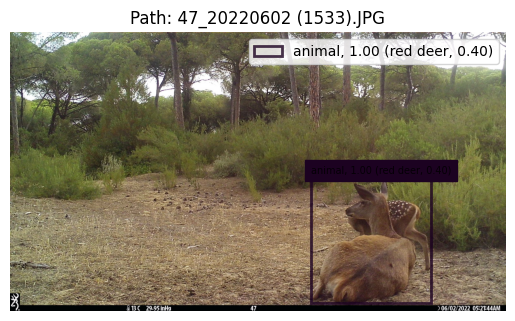

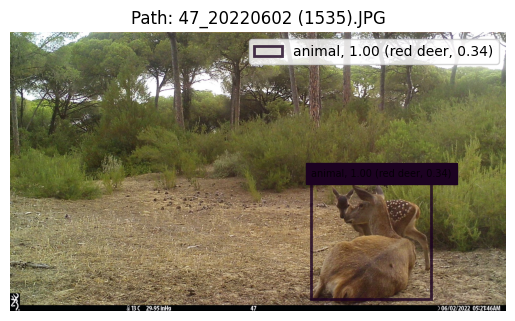

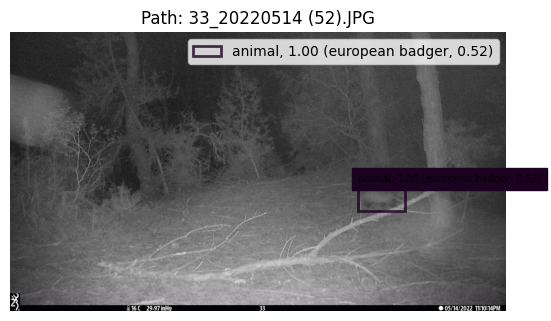

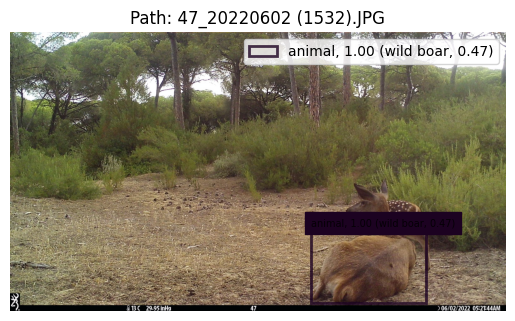

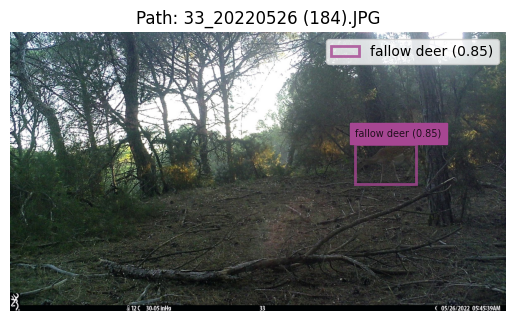

In [84]:
unique_image_ids = unique_imagesids_from_predictions(predictions_data)
random_unique_image_ids = unique_image_ids
random.shuffle(random_unique_image_ids)
plot_n_images_from_imageids_list_old(random_unique_image_ids, 10)

In [ ]:
# plot_n_images_from_imageids_list(["79_20220701 (284).JPG", "80_20220907 (4008).JPG", "53_20220818 (490).JPG"])

plot_n_images_from_imageids_list(["33_20220514 (52).JPG", "33_20220526 (184).JPG", "47_20220602 (1533).JPG", "47_20220602 (1535).JPG", "47_20220602 (1532).JPG"])

IndexError: index 0 is out of bounds for axis 0 with size 0

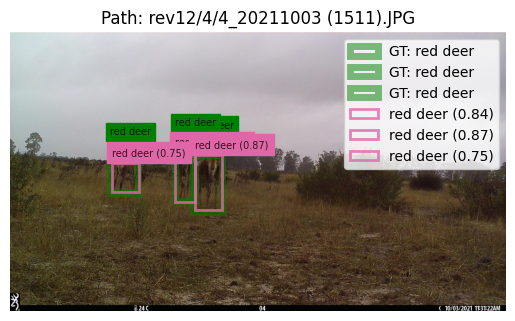

In [ ]:
top_n_image_ids = filter_predictions(predictions_data, mode="worst", n=1, category_id = 12)
plot_n_images_from_imageids_list(top_n_image_ids)

### Plot 1 random image with Ground Truth Bounding Boxes

In [ ]:
# # Select a random row
# random_row = df.sample(n=1, random_state=random.randint(0, 1000)).iloc[0]

# # Plot the random image with YOLO bounding box
# plot_image_with_yolo_bbox(random_row)